In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxopt
import yfinance as yf
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import DiscreteAllocation
from pypfopt import objective_functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import datetime

In [92]:
def getStockPrice(s, lastYearMore = False):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)
    raw = yf.download(s, start=start_date, end=end_date)
    p = raw["Adj Close"].dropna(how="all")
    # Add cash into the dataset

    # Copy last year data to achieve 1.5x weight
    # Add weights
    if lastYearMore:
        recent_year = end_date - pd.DateOffset(years=1)
        recent_data = p[p.index >= recent_year]
        weighted_prices = pd.concat([p, recent_data, recent_data * 0.5])
        return weighted_prices.dropna()

    return p.dropna()

def predict(prices, model="RF"):
    if isinstance(prices, pd.Series):
        prices = prices.to_frame()
    # For each stock, create a Random Forest model and predict the price for next 20 days
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    predicted_changes = pd.Series(index=prices.columns)
    confidence_values = pd.Series(index=prices.columns)
    for s in prices.columns:
        X = np.array(range(len(prices[s]))).reshape(-1, 1)
        y = prices[s].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model == 'RF':
            estimator  = RandomForestRegressor(max_depth=2, random_state=0)
        elif model == 'SVM':
            estimator = SVR(kernel='rbf')
        elif model == 'DT':
            estimator = DecisionTreeRegressor(max_depth=2, random_state=0)
        else:
            raise ValueError(f"Unknown model: {model}")

        estimator.fit(X_train, y_train)

        # Predict for next 20 days
        future = np.array(range(len(prices[s]), len(prices[s]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = estimator.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            estimator.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[s] = y
        change = (y[-1] - y[-21]) / y[-21]
        predicted_changes[s] = change
    for s in prices.columns:
        confidence_values[s] = (predicted_changes[s] - predicted_changes.min()) / (predicted_changes.max() - predicted_changes.min())
    return predicted_prices, predicted_changes, confidence_values


In [93]:
stocks = ['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'SEDG', 'CVX', 'MCD', 'AAPL', 'GS', 'CI', 'NVDA']
stock_prices = getStockPrice(stocks, lastYearMore=True)
index = ['^SPX']
index_price = getStockPrice(index)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  1 of 1 completed


In [94]:
mcaps = {}
for t in stocks:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]

## Constructing the piror
### Random forest has the best performance towards to decision tree and SVM

In [95]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [96]:
p_price, p_change, p_confidence = predict(stock_prices, model="RF")
# predict_index_price = predict(index_price)
S = risk_models.CovarianceShrinkage(p_price).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(index_price)
delta

2.1786639159260335

In [97]:
delta

2.1786639159260335

In [98]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.298556
AMZN     0.274513
BSX      0.208801
CI       0.165749
COST     0.184703
CVX      0.178398
GOOGL    0.250668
GS       0.191841
HSBC     0.178501
LMT      0.150306
MCD      0.168958
MRK      0.158504
MSFT     0.288499
NVDA     0.415513
PFE      0.090212
SEDG     0.231122
TSLA     0.314426
dtype: float64

## Views

In [99]:
viewdict = (p_change+0.3).to_dict()
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=p_confidence.values)

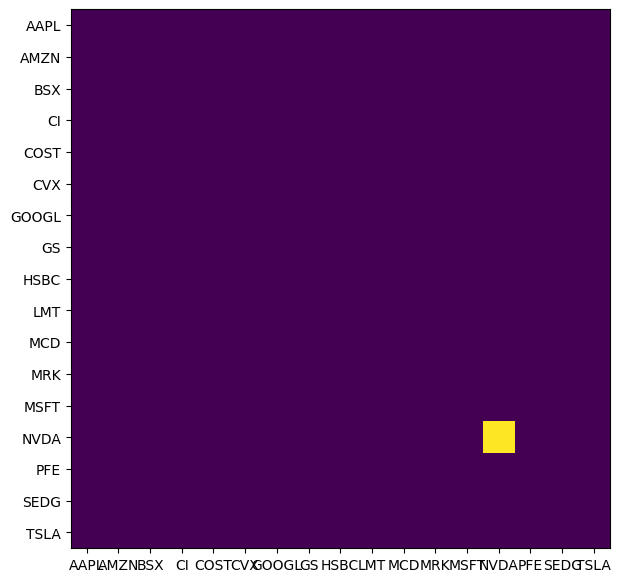

In [100]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [101]:
np.diag(bl.omega)

array([8.36044575e-03, 1.02189830e-02, 3.22581496e-03, 2.42073982e-03,
       2.10135270e-03, 8.07748150e-04, 4.41974314e-03, 6.19310171e-04,
       3.15734328e-03, 7.61856274e-04, 1.37824209e-03, 1.81833870e-03,
       8.95495949e-03, 1.00000000e+06, 0.00000000e+00, 3.34873885e-05,
       1.61401593e-02])

In [102]:
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.227371
AMZN     0.182292
BSX      0.227033
CI       0.246223
COST     0.221036
CVX      0.314801
GOOGL    0.207503
GS       0.320259
HSBC     0.216599
LMT      0.297783
MCD      0.252479
MRK      0.240300
MSFT     0.214944
NVDA     0.289950
PFE      0.372453
SEDG     0.371211
TSLA     0.207120
dtype: float64

In [103]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.298556,0.227371,0.099090
AMZN,0.274513,0.182292,0.081605
BSX,0.208801,0.227033,0.208268
CI,0.165749,0.246223,0.235716
COST,0.184703,0.221036,0.228726
CVX,0.178398,0.314801,0.322381
GOOGL,0.250668,0.207503,0.170671
GS,0.191841,0.320259,0.330101
HSBC,0.178501,0.216599,0.207734
LMT,0.150306,0.297783,0.312060


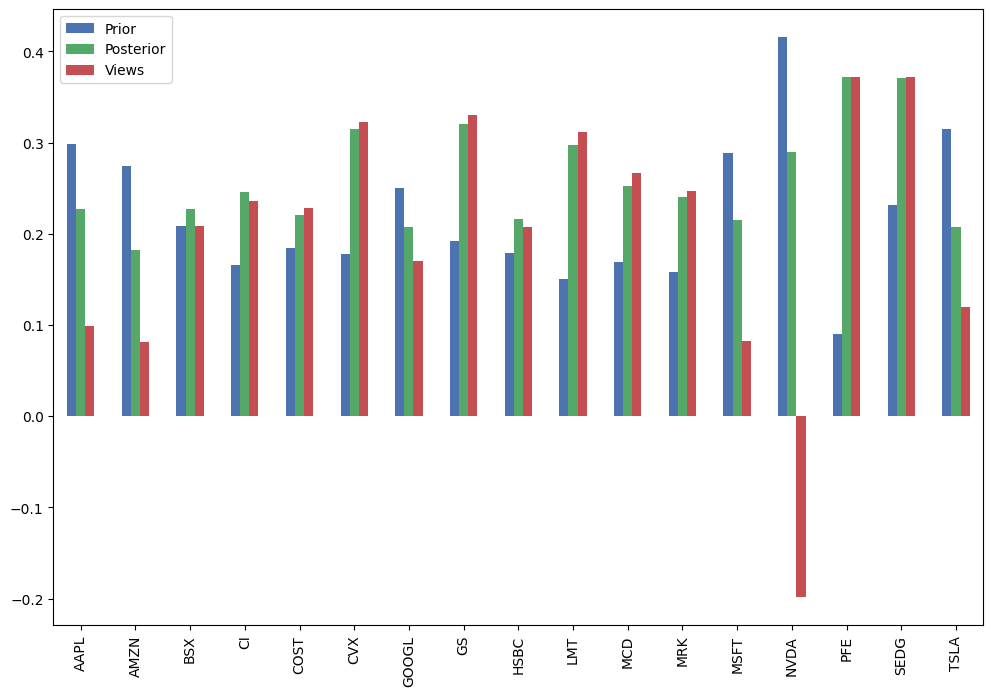

In [104]:
rets_df.plot.bar(figsize=(12,8));

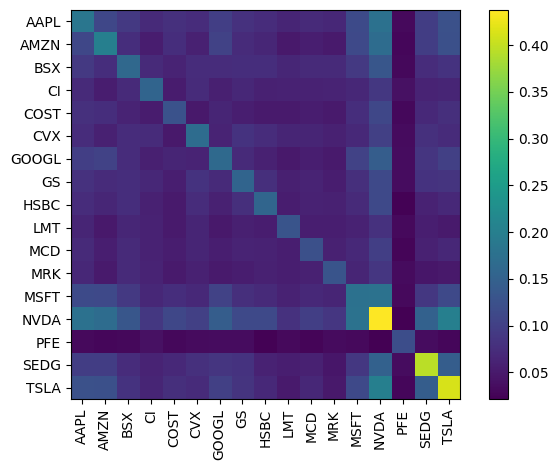

In [105]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [106]:
from pypfopt import EfficientFrontier, objective_functions

In [107]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.add_constraint(lambda w: w <= 0.10)
ef.add_constraint(lambda w: w >= 0.05)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.05),
             ('AMZN', 0.05),
             ('BSX', 0.05),
             ('CI', 0.05),
             ('COST', 0.05),
             ('CVX', 0.07291),
             ('GOOGL', 0.05),
             ('GS', 0.07384),
             ('HSBC', 0.05),
             ('LMT', 0.07654),
             ('MCD', 0.05),
             ('MRK', 0.05),
             ('MSFT', 0.05),
             ('NVDA', 0.05),
             ('PFE', 0.1),
             ('SEDG', 0.07671),
             ('TSLA', 0.05)])

In [108]:
ret_bl

AAPL     0.227371
AMZN     0.182292
BSX      0.227033
CI       0.246223
COST     0.221036
CVX      0.314801
GOOGL    0.207503
GS       0.320259
HSBC     0.216599
LMT      0.297783
MCD      0.252479
MRK      0.240300
MSFT     0.214944
NVDA     0.289950
PFE      0.372453
SEDG     0.371211
TSLA     0.207120
dtype: float64

In [109]:
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=False)
sharpe_ratio

0.9107961391112768

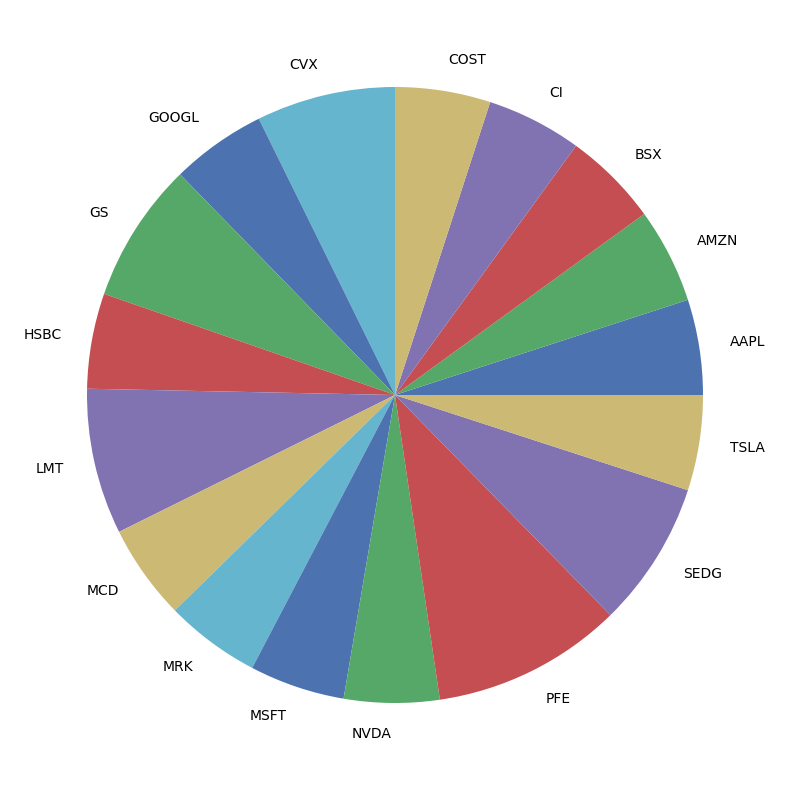

In [110]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [111]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, stock_prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $139.62


/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 16,
 'BSX': 40,
 'CI': 7,
 'COST': 4,
 'CVX': 19,
 'GOOGL': 18,
 'GS': 9,
 'HSBC': 56,
 'LMT': 7,
 'MCD': 7,
 'MRK': 18,
 'MSFT': 6,
 'NVDA': 5,
 'PFE': 115,
 'SEDG': 12,
 'TSLA': 8}